In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [ ]:
import gc
import torch
import torchvision

from config import (
    IMAGE_DIMENSION_INTEL,
    IMAGE_DIMENSION_150,
    get_device,
)
from utils import download_intel, get_data_loaders, print_model_summary

print(torch.__version__)
print(torchvision.__version__)


DEVICE: torch.device = get_device()

2.10.0+cu128
0.25.0+cu128
Using DEVICE: cuda


In [ ]:
train_dataset, test_dataset = download_intel(img_dimensions=IMAGE_DIMENSION_150)


print("\nDataset Statistics:")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")


Intel ready  train=14034  test=3000  channels=3

Dataset Statistics:
Training samples: 14034
Testing samples: 3000
Number of classes: 6
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [4]:
train_dataloader, test_dataloader, class_names, data_channel = get_data_loaders(
    test_dataset=test_dataset, train_dataset=train_dataset, batch_size=32
)

print("DataLoader Information:")
print(f"Train batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

DataLoader Information:
Train batches: 439
Test batches: 94


In [5]:
from utils import set_seed
from config import BranchType, FilterType
from models import HalkaNet

set_seed()

model_intel_train = HalkaNet(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1.5, BranchType.FILTER: 1.5},
    rgb_stem_channels=16,
    filter_channels=20,
    filters=[FilterType.LOG, FilterType.LBP, FilterType.WAVE, FilterType.GABOR],
    tail_depth=2,
)


In [ ]:
print_model_summary(model=model_intel_train, img_dim=IMAGE_DIMENSION_150)


Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                      [1, 3, 150, 150]          [1, 6]                    --                        --
├─Conv2d: 1-1                                 [1, 3, 150, 150]          [1, 1, 150, 150]          (3)                       67,500
├─Sequential: 1-2                             [1, 3, 150, 150]          [1, 40, 37, 37]           --                        --
│    └─Conv2d: 2-1                            [1, 3, 150, 150]          [1, 16, 150, 150]         48                        1,080,000
│    └─BatchNorm2d: 2-2                       [1, 16, 150, 150]         [1, 16, 150, 150]         32                        32
│    └─ReLU: 2-3                              [1, 16, 150, 150]         [1, 16, 150, 150]         --                        --
│    └─DepthwiseSeparableConv: 2-4            [1, 16, 150, 150]         [1, 16, 75, 75]      

In [7]:
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
from utils import evaluate_tta, run_experiment
from config import (
    CHECKPOINT_DIR,
    EPOCHS_PRO_MAX,
    WEIGHT_DECAY,
    LABEL_SMOOTHING,
)

results = run_experiment(
    halkanet=model_intel_train,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_INTEL,
    epochs=EPOCHS_PRO_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=False,
    save_best=False,
    checkpoint_dir=f"{CHECKPOINT_DIR}/solo/intel_150x150_model",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)



  Training HalkaNet

Model: 392,470 params | Dataset: 14,034 samples | base_lr: 2e-03
Warmup: 8 epochs → peak 2e-03 | Cosine: 92 epochs → 1.6e-06
LR preview:
  Epoch   1: 2.00e-04
  Epoch   2: 4.25e-04
  Epoch   3: 6.50e-04
  Epoch   4: 8.75e-04
  Epoch   5: 1.10e-03
  Epoch   9: 2.00e-03
  Epoch  98: 6.24e-06
  Epoch  99: 3.33e-06
  Epoch 100: 1.58e-06
EMA decay: 0.9995  (≈5-epoch window, 2195 steps)

Starting 100 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→100)

Epoch   1/100 | LR: 0.00043
  Train  Acc: 70.17%  Loss: 1.0368
  Test   Acc: 17.45%  Loss: 2.2053
Best saved (Test Acc: 17.45%)
-----------------------------------
Epoch   2/100 | LR: 0.00065
  Train  Acc: 80.04%  Loss: 0.8458
  Test   Acc: 28.86%  Loss: 1.9631
Best saved (Test Acc: 28.86%)
-----------------------------------
Epoch   3/100 | LR: 0.00088
  Train  Acc: 83.62%  Loss: 0.7802
  Test   Acc: 18.09%  Loss: 2.0918
-----------------------------------
Epoch   4/100 | LR: 0.00110
  Train  Acc: 85.31%  Loss: 0

In [9]:
tta_acc = evaluate_tta(
    model=model_intel_train, test_loader=test_dataloader, device=DEVICE
)
tta_acc

0.9200000166893005

Generating predictions for Confusion Matrix...


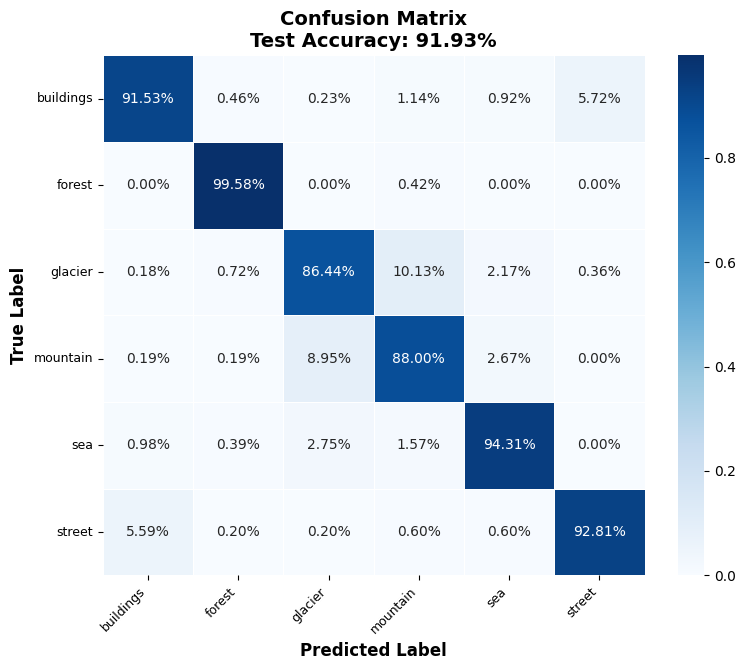


Most Confused Pairs (Errors > 10.00%):
  - True 'glacier' predicted as 'mountain': 10.1%


In [10]:
from utils import plot_confusion_matrix

plot_confusion_matrix(
    model=model_intel_train,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    threshold=0.1,
)


In [11]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)



────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               91.93% 99.87%    392,473      98.6      1.57    7.87   127.1  ◄
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 91.93% Top-1 | 392,473 params | 7.87 ± 0.74 ms | 127.1 FPS



Saved → ../figure/solo/train_intel_150x150.pdf / .png


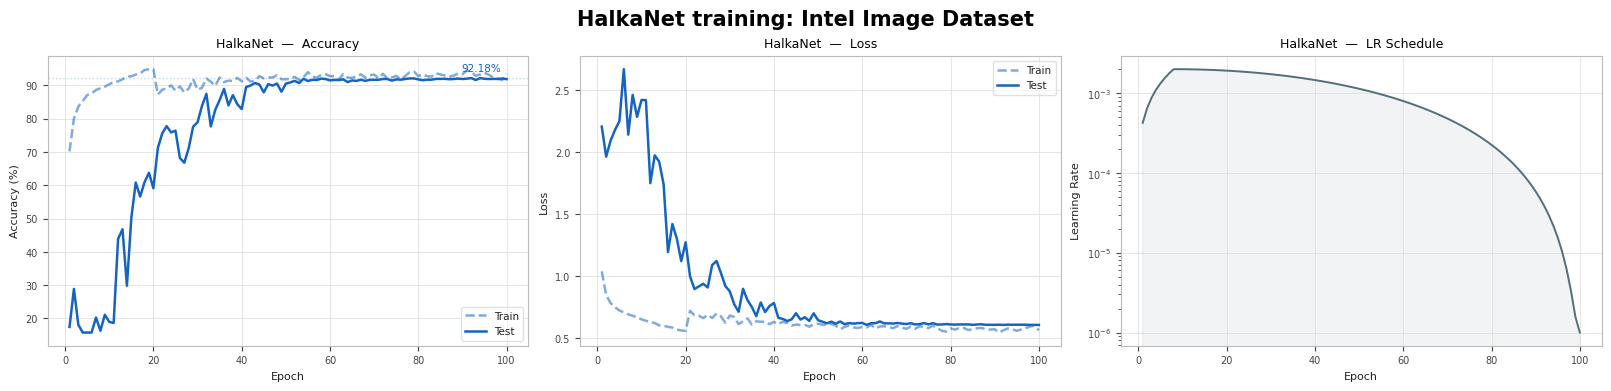

In [12]:
plot_training_curves(
    results,
    save_path=f"{FIGURE_DIR}/solo/train_intel_150x150.pdf",
    dataset_name="Intel Image Dataset",
    title="HalkaNet training:",
)
